In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
snacks_df = pd.read_csv('./datasets/snacks.csv', dtype = { 'client_id': str })

In [3]:
snacks_df.head()

,country_region,office_department_city,description,area_name,warehouse_id,warehouse_city,category_id,category_name,brand_id,price_type,...,client_name,point_of_sale_name,distributor,date,units,devolution_units,currency,sale_amount,sale_discount,sale_devolution
0,Centro,Ibague,IBAGUE 1,SALADO,85228.0,IBAGUE,CAT1,Producto de Extrusion,M01,REGULAR,...,NaN,NaN,Tiendas,1/04/2014,39600,0,COP,"493,529.00","-93,769.56",0
1,Sur,Cali,TULUA,EL PRINCIPE,85205.0,TULUA,CAT1,Producto de Extrusion,M01,OFERTADO,...,NaN,NaN,Tiendas,1/04/2014,324,0,COP,"181,530.00","-32,675.40",0
2,Sur,Nariño,POPAYAN,MOTO CONQUISTA POPAYAN,85220.0,POPAYAN,CAT1,Producto de Extrusion,M01,OFERTADO,...,NaN,NaN,Tiendas,1/04/2014,36,0,COP,"20,170.00","-4,437.40",0
3,Sur,Nariño,POPAYAN,MOTO CONQUISTA POPAYAN,85220.0,POPAYAN,CAT1,Producto de Extrusion,M01,REGULAR,...,NaN,NaN,Tiendas,1/04/2014,73200,0,COP,"91,227.00","-20,069.98",0
4,Norte,Bucaramanga,FLORIDA,REPOSO,85230.0,BUCARAMANGA,CAT1,Producto de Extrusion,M01,OFERTADO,...,NaN,NaN,Tiendas,1/04/2014,3924,0,COP,"2,198,533.00","-395,736.97",0


In [4]:
snacks_df['country_region'].unique()

array([' Centro', ' Sur', ' Norte', 'Ventas al Exterior', 'Norte',
       'Centro', nan, 'Sur', 'Ventas Miscelaneas'], dtype=object)

In [5]:
snacks_df['country_region'] = snacks_df['country_region'].str.strip()
snacks_df['country_region'].unique()

array(['Centro', 'Sur', 'Norte', 'Ventas al Exterior', nan,
       'Ventas Miscelaneas'], dtype=object)

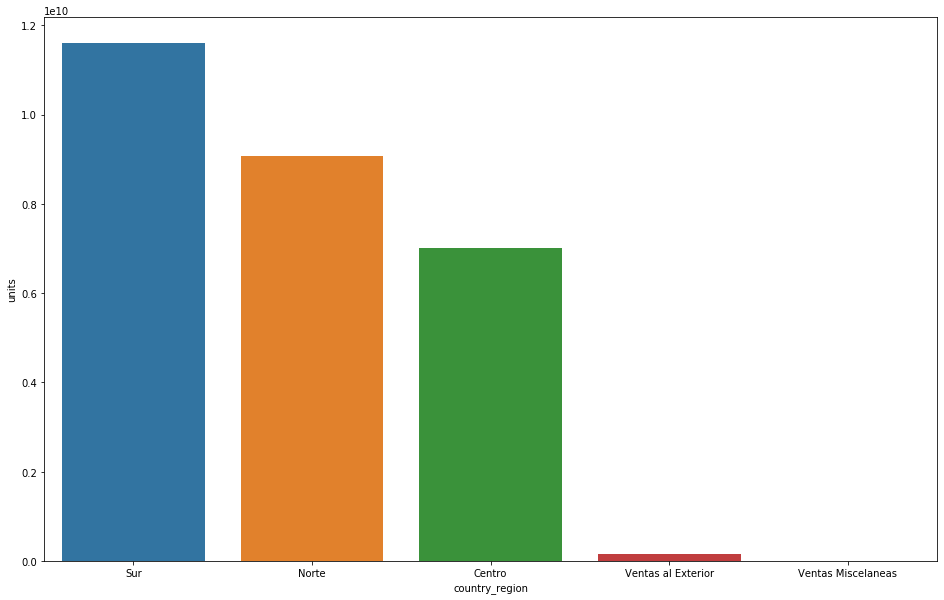

In [6]:
group = snacks_df.groupby('country_region')['units'].sum().reset_index(name='units').sort_values('units', ascending=False)

plt.figure(figsize=(16, 10))
sns.barplot(x='country_region', y='units', data=group)

In [7]:
clean_df = snacks_df[snacks_df['country_region'] == 'Sur']
clean_df.shape

(1213737, 26)

In [8]:
clean_df['category_name'].isna().sum()

101433

In [9]:
to_rename = {
    'pruduction_line': 'production_line',
    'office_department_city': 'office_name',
    'warehouse_city': 'warehouse_name'
}
clean_df = clean_df.rename(columns=to_rename)

In [10]:
clean_df = clean_df[clean_df['distributor'].notna()]
clean_df['distributor'].isna().any()

False

In [11]:
clean_df['incentive'] = clean_df['price_type'].apply(lambda x: True if x == 'OFERTADO' else False)

In [12]:
clean_df = clean_df.drop([
    'production_line',
    'warehouse_id',
    'area_name',
    'weight',
    'currency',
    'category_id',
    'plant',
    'client_id',
    'price_type',
    'country_region'
], axis=1)
clean_df.shape

(1213721, 17)

In [13]:
float_columns = ['sale_amount', 'sale_discount', 'sale_devolution']
for column in float_columns:
    clean_df[column] = clean_df[column].str.replace(',', '').astype(float)

In [14]:
brand_names = {
    'M01': 'Cheetos',
    'M02': 'Popcorn',
    'M03': 'Cheetos',
    'M08': 'Criollas',
    'M07': 'Ruffles',
    'M16': 'Todo en uno',
    'Otras': 'Dulces',
    'M27': 'Surtidas',
    'M25': 'Costillas',
    'M24': 'Choclos',
    'M11': 'Ruffles econo',
    'M20': 'Tortillitas',
    'M14': 'Criollas econo',
    'M18': 'Caleñas',
    'M17': 'Surtidas',
    'M23': 'Nachos',
    'M28': 'Fritas econo',
    'M13': 'Platanos econo',
    'M26': 'Costillas econo',
    'M09': 'Papas econo'
}

def name_brand(x):
    if x in brand_names.keys():
        return brand_names[x]
    else:
        return x

In [15]:
clean_df['brand_id'] = clean_df['brand_id'].apply(name_brand)
clean_df = clean_df.rename(columns={'brand_id': 'brand'})

In [16]:
clean_df['category_name'] = clean_df['category_name'].fillna('Dulces')

In [17]:
def get_warehouse_name(name):
    if name is np.nan:
        return name
    algo = clean_df[clean_df['description'].str.contains(name) | False].groupby('warehouse_name')['date'].count().reset_index().sort_values('date')
    if len(algo) == 0:
        return np.nan
    return algo.iloc[-1]['warehouse_name']

descriptions = clean_df[clean_df['warehouse_name'].isna()]['description'].unique()
desc_warehouse_dict = {}

for each in descriptions:
    desc_warehouse_dict[each] = get_warehouse_name(each)

desc_warehouse_dict['VENTA DIRECTA MEDELLIN'] = 'SUR'

In [18]:
clean_df.loc[clean_df['warehouse_name'].isna(), 'warehouse_name'] = clean_df[clean_df['warehouse_name'].isna()]['description'].map(desc_warehouse_dict)
clean_df = clean_df.drop(['description'], axis=1)

In [19]:
to_rename = {
    'office_name': 'office',
    'warehouse_name': 'warehouse',
    'category_name': 'category',
    'flavor_name': 'flavor',
    'client_name': 'client',
    'point_of_sale_name': 'point_of_sale'
}
clean_df = clean_df.rename(columns=to_rename)

In [23]:
# Normalize categorical columns
# office, warehouse, category, brand, flavor, client, point_of_sale, distributor
columns = ['office', 'warehouse', 'category', 'brand', 'flavor', 'client', 'point_of_sale', 'distributor']
for column in columns:
    clean_df[column] = clean_df[column].map(lambda name: name.title() if isinstance(name, str) else name)

In [26]:
columns = ['sale_discount', 'sale_devolution']

for column in columns:
    if (clean_df[column] <= 0).all():
        clean_df[column] *= -1

In [27]:
clean_df.head()

,office,warehouse,category,brand,product_id,flavor,client,point_of_sale,distributor,date,units,devolution_units,sale_amount,sale_discount,sale_devolution,incentive
1,Cali,Tulua,Producto De Extrusion,Cheetos,53407164,Tradicional,NaN,NaN,Tiendas,1/04/2014,324,0,181530.0,32675.40,-0.0,True
2,Nariño,Popayan,Producto De Extrusion,Cheetos,53407164,Tradicional,NaN,NaN,Tiendas,1/04/2014,36,0,20170.0,4437.40,-0.0,True
3,Nariño,Popayan,Producto De Extrusion,Cheetos,53102174,Tradicional,NaN,NaN,Tiendas,1/04/2014,73200,0,91227.0,20069.98,-0.0,False
8,Cali,Sur,Producto De Extrusion,Cheetos,53408215,Tradicional,NaN,NaN,Tiendas,1/04/2014,1080,0,605100.0,108918.43,-0.0,True
10,Cali,Norte,Producto De Extrusion,Cheetos,53408024,Tradicional,NaN,NaN,Superficies Menores,1/04/2014,100,40,73280.0,10992.00,29312.0,True


In [29]:
clean_df.to_csv('./datasets/clean_snacks.csv', encoding='utf-8', index=False)